<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/autoencoders/DUDL_autoenc_tiedWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# An aside on Linear vs. Parameter classes

In [ ]:
# create an input and weights matrix
x  = torch.rand(10,50)
W1 = nn.Parameter(torch.randn(128,50))

# Let's see what W1 is
print(W1)
print('\n\n')

# # Its size and the size of its transpose
# print(W1.shape)
# print(W1.t().shape)
# print('\n\n')

# # compute an output
# y = x@W1
# print(y.shape)

In [6]:
# Create an input and weights matrix
x  = torch.randn(10, 50)
W1 = nn.Parameter(torch.randn(128, 50)) 

print(W1, '\n\n', W1.shape, '\n\n', W1.t().shape, '\n\n')

# Compute output
y = x @ W1.t()
print(y.shape)

Parameter containing:
tensor([[-1.8677, -0.3999,  1.9266,  ..., -0.0645, -1.3852,  0.1213],
        [-1.8545,  0.8186,  0.5536,  ..., -0.0849,  0.6692, -0.5356],
        [-0.0862,  1.7854, -2.0095,  ..., -0.0621,  0.0514, -0.2294],
        ...,
        [-0.0318, -0.4505, -1.2460,  ...,  1.2932,  1.1061,  1.4948],
        [-1.2404,  1.0557,  0.2974,  ..., -0.4232,  0.9341,  0.0267],
        [-0.6298,  1.5737,  0.1564,  ...,  1.7950,  0.7087,  0.4403]],
       requires_grad=True) 

 torch.Size([128, 50]) 

 torch.Size([50, 128]) 


torch.Size([10, 128])


In [10]:
# Linear method
W2 = nn.Linear(128, 50)
print(W2, '\n\n', W2.weight.shape, '\n\n', W2.weight.t().shape)

# Compute an output
y = x @ (W2.weight)
print(y.shape)

Linear(in_features=128, out_features=50, bias=True) 

 torch.Size([50, 128]) 

 torch.Size([128, 50])
torch.Size([10, 128])


In [11]:
# Confusion from the previous cells
print(W1.shape)
print(W2.weight.shape)

# confusion solved ;)
# (size of W -> [outputs,inputs], but nn.Linear expects [inputs,outputs])

torch.Size([128, 50])
torch.Size([50, 128])


In [ ]:
# see all attributes of the class Linear
dir(nn.Linear)

# and the docstring for Linear.forward
# ??nn.Linear.forward()
# ??nn.Linear.__init__() # note the inputs vs. how weight is created

# Import and process the data

In [14]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()

# Create the DL model

In [12]:
# Create a class for the model
def create_the_MNIST_AE():
    """
    AUTOENCODER_TIE_WEIGHTS
    """
    class ae_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 128)

            # Encoder layer
            self.enc = nn.Parameter(torch.randn(50, 128))

            # Decoder layer
            self.dec = nn.Linear(128, 784)
    
        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))

            # A Parameter type is not a Linear type, so we implement the multiplication directly
            # Need to transpose the input matrix due to multisample input matrices
            x = x.t()
            x = F.relu(self.enc @ x)

            # Same for the decoding layer but reversed
            x = F.relu(self.enc.t() @ x)
            # And then transpose it back
            x = x.t()

            y = torch.sigmoid(self.dec(x))

            return y
    
    # Create the model instance
    net = ae_net()

    # Loss function
    loss_func = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    return net, loss_func, optimizer

In [17]:
# Test the model with a bit of data
net, loss_func, optimizer = create_the_MNIST_AE()

X     = data_tensor[:5, :]
y_hat = net(X)

print(f'Input shape: {X.shape}')
print(y_hat.shape)
print(type(y_hat), len(y_hat))

Input shape: torch.Size([5, 784])
torch.Size([5, 784])
<class 'torch.Tensor'> 5


# Create a function that trains the model

In [18]:
def train_the_model():
    """
    AUTOENCODER_DENOISING_MNIST|LATENT_CODE|TIE_WEIGHTS
    """

    num_epochs = 10000

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_AE()

    # Initialize losses
    losses = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Select a random set of images
        random_idx = np.random.choice(data_tensor.shape[0], size=32)
        X          = data_tensor[random_idx, :]

        # Forward pass and loss
        y_hat = net(X)
        loss  = loss_func(y_hat, X)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Losses in this epoch
        losses[epoch_i] = loss.item()
    
    # End epochs
    # Function output
    return losses, net

# Run the model and show the results!

Final loss: 0.0129


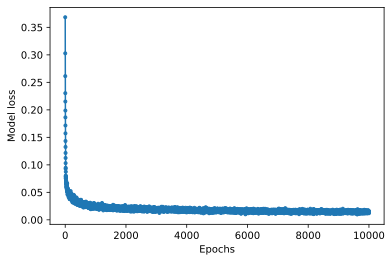

In [19]:
# Train the model
losses, net = train_the_model()
print(f'Final loss: {losses[-1]:.4f}')

# Visualize the losses
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

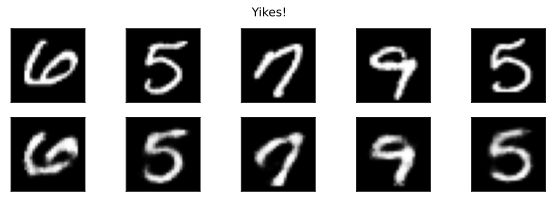

In [20]:
# Visualization of inputs and outputs
X     = data_tensor[:5, :]
y_hat = net(X)

# Let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X    [i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(y_hat[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle('Yikes!')
plt.show()

# Add noise to see a use case of an autoencoder

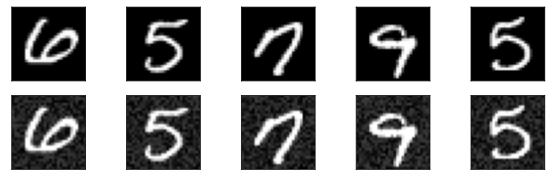

In [21]:
# Grab a small set of images
X = data_tensor[:10, :]

# Add noise
X_noise = X + torch.rand_like(X) / 4

# Clip at 1
X_noise[X_noise > 1] = 1

# Show the noisy image
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X      [i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(X_noise[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

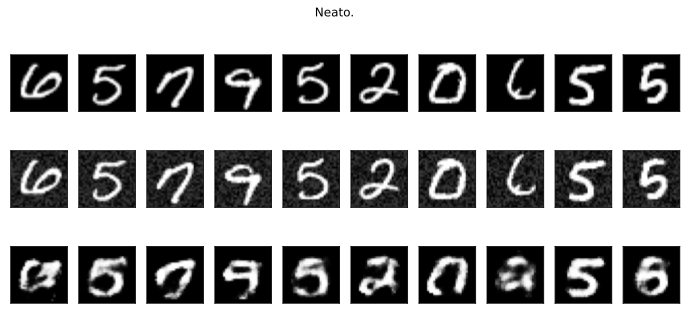

In [22]:
# Run through the model
Y = net(X_noise)

fig, axs = plt.subplots(3, 10, figsize=(12, 5))

for i in range(10):
    axs[0, i].imshow(X      [i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(X_noise[i, :].view(28, 28).detach(), cmap='gray')
    axs[2, i].imshow(Y[i, :]      .view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle('Neato.')
plt.show()

# Additional explorations

In [ ]:
# 1) The network we built here is not a truly mirrored network: We tied the encoder/decoder layers, but left the input
#    and output layers separate. That's not wrong or bad or anything; it's just a choice. Modify the code to create
#    a truly mirrored network, where all decoding layers are tied to their corresponding encoding layers.
# 
# 2) You don't need to use nn.Parameter; you can still accomplish what we did by using nn.Linear and extracting the
#    weights matrices. Rewrite the code to use nn.Linear instead of nn.Parameter.
# 